## **Data Quantity By Product-Store Combination**

In [2]:
# ── Setup ────────────────────────────────────────────────────────────────────
from pyspark.sql import functions as F
from pyspark.sql import Window

# Tables (adjust the catalog / database names if they differ)
fs  = spark.table("Gold_Data.fact_sales.fact_sales")   # fact table
dd  = spark.table("Gold_Data.dim_date.dim_date")       # date dimension

# ── 1. date_counter ──────────────────────────────────────────────────────────
date_counter = (
    fs.alias("fs")
      .join(dd.alias("dd"), F.col("fs.date_id") == F.col("dd.date_id"))
      .groupBy("fs.product_key", "fs.store_key")
      .agg(F.max("dd.full_date").alias("last_actual_date_registered"))
)

# ── 2. weekly_sales_prepared ────────────────────────────────────────────────
week_start = F.date_trunc("week", F.col("dd.full_date"))             # Monday of each week
cutoff     = F.to_date(F.lit("2019-10-31"))

weekly_sales_prepared = (
    fs.alias("fs")
      .join(dd.alias("dd"), F.col("fs.date_id") == F.col("dd.date_id"))
      .join(date_counter.alias("dc"),
            (F.col("fs.product_key") == F.col("dc.product_key")) &
            (F.col("fs.store_key")   == F.col("dc.store_key")))
      .where(F.col("dc.last_actual_date_registered") == cutoff)
      .select(
          "fs.product_key",
          "fs.store_key",
          week_start.alias("week_start_date")
      )
      .distinct()
)

# ── 3. ranked_weeks ─────────────────────────────────────────────────────────
week_seq_num = F.floor(F.datediff("week_start_date", F.lit("1900-01-01")) / 7)

w_rownum = Window.partitionBy("product_key", "store_key").orderBy("week_start_date")

ranked_weeks = (
    weekly_sales_prepared
      .withColumn("week_seq_num", week_seq_num)
      .withColumn("rn", F.row_number().over(w_rownum))
)

# ── 4. grouped_weeks ────────────────────────────────────────────────────────
grouped_weeks = ranked_weeks.withColumn("grp", F.col("week_seq_num") - F.col("rn"))

# ── 5. consecutive_week_counts ─────────────────────────────────────────────
consecutive_week_counts = (
    grouped_weeks.groupBy("product_key", "store_key", "grp")
                 .agg(
                     F.min("week_start_date").alias("start_week_date"),
                     F.max("week_start_date").alias("end_week_date"),
                     F.count("*").alias("consecutive_weeks")
                 )
)

# ── 6. exact_consecutive_distribution ──────────────────────────────────────
monday_of_cutoff = F.date_trunc("week", cutoff)   # → 2019-10-28

exact_consecutive_distribution = (
    consecutive_week_counts.alias("c")
      .join(date_counter.alias("dc"),
            (F.col("c.product_key") == F.col("dc.product_key")) &
            (F.col("c.store_key")   == F.col("dc.store_key")))
      .where(
          (F.col("dc.last_actual_date_registered") == cutoff) &
          (F.col("c.end_week_date") == monday_of_cutoff)
      )
      .groupBy("c.consecutive_weeks")
      .agg(
          F.countDistinct("c.product_key", "c.store_key")
           .alias("number_of_combinations_exact")
      )
)

# ── 7. cumulative distribution ─────────────────────────────────────────────
w_cume = (
    Window.orderBy(F.desc("consecutive_weeks"))
          .rowsBetween(Window.unboundedPreceding, Window.currentRow)
)

result_df = (
    exact_consecutive_distribution
      .withColumn(
          "number_of_combinations_at_least",
          F.sum("number_of_combinations_exact").over(w_cume)
      )
      .orderBy(F.desc("consecutive_weeks"))
)

# ── Display / persist ──────────────────────────────────────────────────────
result_df.show()           # Databricks notebook UI (or use .show())



StatementMeta(, 52a73b92-67be-4fe4-9a7a-aa2dc0866299, 4, Finished, Available, Finished)

+-----------------+----------------------------+-------------------------------+
|consecutive_weeks|number_of_combinations_exact|number_of_combinations_at_least|
+-----------------+----------------------------+-------------------------------+
|              148|                        2213|                           2213|
|              147|                          32|                           2245|
|              146|                          30|                           2275|
|              145|                           8|                           2283|
|              144|                           9|                           2292|
|              143|                          11|                           2303|
|              142|                          10|                           2313|
|              141|                          14|                           2327|
|              140|                          10|                           2337|
|              139|         

StatementMeta(, 52a73b92-67be-4fe4-9a7a-aa2dc0866299, 7, Finished, Available, Finished)

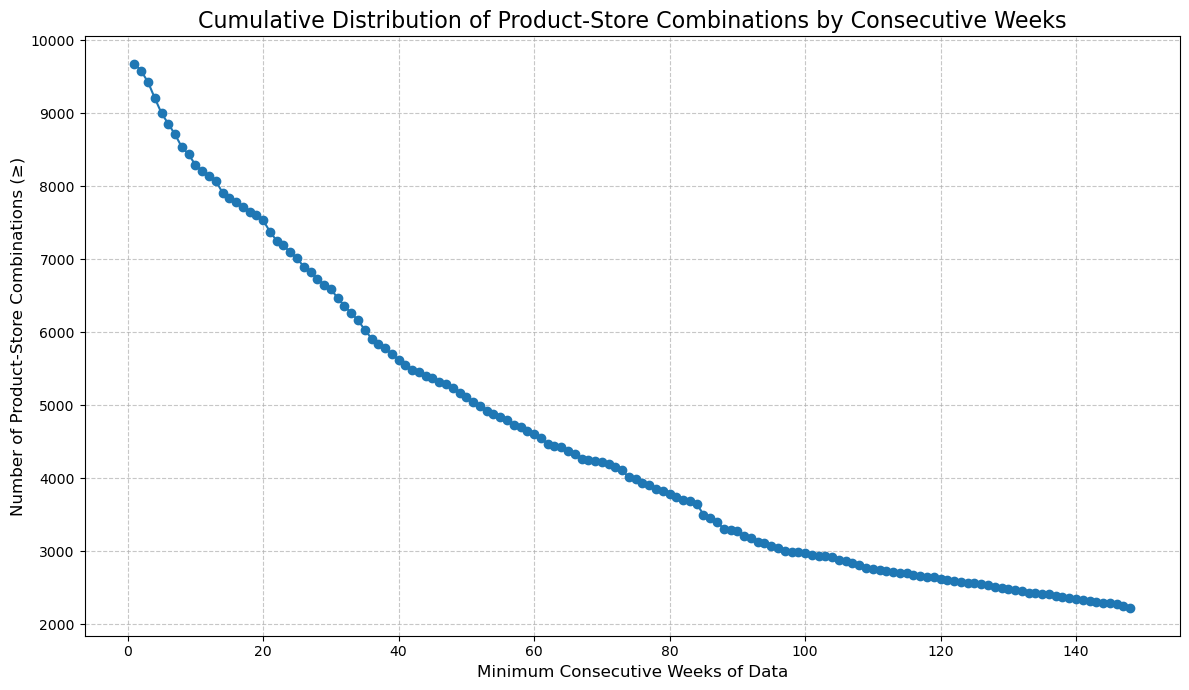


--- Key Data Points ---
Total product-store combinations with ≥ 1 week:  9681
Combinations with ≥ 52 weeks:  4985
Combinations with ≥ 104 weeks: 2914
Combinations with ≥ 148 weeks: 2213


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Collect as pandas 
df = result_df.toPandas().sort_values('consecutive_weeks')  # ascending now

# 2. Plot cumulative distribution
plt.figure(figsize=(12, 7))
plt.plot(df['consecutive_weeks'],
         df['number_of_combinations_at_least'],
         marker='o', linestyle='-')          # let default colour pick itself
plt.title('Cumulative Distribution of Product-Store Combinations by Consecutive Weeks', fontsize=16)
plt.xlabel('Minimum Consecutive Weeks of Data', fontsize=12)
plt.ylabel('Number of Product-Store Combinations (≥)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Key numbers
total          = df['number_of_combinations_at_least'].max()    # ≥ 1 week
at_least_52    = df.loc[df['consecutive_weeks'] >=  52, 'number_of_combinations_at_least'].max()
at_least_104   = df.loc[df['consecutive_weeks'] >= 104, 'number_of_combinations_at_least'].max()
at_least_148   = df.loc[df['consecutive_weeks'] >= 148, 'number_of_combinations_at_least'].max()

print("\n--- Key Data Points ---")
print(f"Total product-store combinations with ≥ 1 week:  {total}")
print(f"Combinations with ≥ 52 weeks:  {at_least_52}")
print(f"Combinations with ≥ 104 weeks: {at_least_104}")
print(f"Combinations with ≥ 148 weeks: {at_least_148}")


## **Conclusão**

- Tendo em conta o gráfico, decidimos utilizar 104 semanas de dados. 

## **Original Query**

In [ ]:
%%sql
WITH date_counter AS (
    -- Get the last *actual* date (full_date from dim_date) registered for each product-store combination.
    -- This CTE is crucial for filtering the main dataset to only include relevant products
    -- (i.e., those whose last recorded activity was precisely '20191031').
    SELECT
        fs.product_key,
        fs.store_key,
        MAX(dd.full_date) AS last_actual_date_registered
    FROM
        Gold_Data.fact_sales.fact_sales AS fs
    JOIN
        Gold_Data.dim_date.dim_date AS dd -- Join with dim_date table
    ON
        fs.date_id = dd.date_id -- Join on date_id
    GROUP BY
        fs.product_key,
        fs.store_key
),
weekly_sales_prepared AS (
    -- For the product-store combinations identified in 'date_counter'
    -- that had their last activity on '20191031', we prepare their weekly sales data.
    -- We directly use the 'full_date' from dim_date, which is already a proper date type.
    -- DATE_TRUNC('week', ...) finds the start date of each week a sale occurred.
    -- DISTINCT ensures we only have one entry per product_key, store_key, and week_start_date.
    SELECT DISTINCT
        fs.product_key,
        fs.store_key,
        DATE_TRUNC('week', dd.full_date) AS week_start_date -- Use full_date directly
    FROM
        Gold_Data.fact_sales.fact_sales AS fs
    JOIN
        Gold_Data.dim_date.dim_date AS dd -- Join with dim_date table
    ON
        fs.date_id = dd.date_id -- Join on date_id
    JOIN
        date_counter AS dc
    ON
        fs.product_key = dc.product_key
        AND fs.store_key = dc.store_key
    WHERE
        dc.last_actual_date_registered = CAST('2019-10-31' AS DATE) -- Filter using the DATE type
),
ranked_weeks AS (
    -- We rank the 'week_start_date' for each product-store combination to help
    -- identify gaps in their weekly data.
    -- DATEDIFF(WEEK, '1900-01-01'::DATE, week_start_date) calculates a sequential
    -- integer week number from a fixed reference date (Jan 1, 1900). This is more robust
    -- for arithmetic than direct week numbers which might restart each year.
    SELECT
        product_key,
        store_key,
        week_start_date,
        DATEDIFF(WEEK, CAST('1900-01-01' AS DATE), week_start_date) AS week_seq_num,
        ROW_NUMBER() OVER (PARTITION BY product_key, store_key ORDER BY week_start_date) AS rn
    FROM
        weekly_sales_prepared
),
grouped_weeks AS (
    -- This CTE identifies consecutive weekly sequences.
    -- If weeks are truly consecutive (e.g., Week N, Week N+1, Week N+2), then
    -- the difference between 'week_seq_num' and its 'rn' (row number) will be constant
    -- for that consecutive block. This 'grp' value acts as a unique ID for each sequence.
    SELECT
        product_key,
        store_key,
        week_start_date,
        (week_seq_num - rn) AS grp
    FROM
        ranked_weeks
),
consecutive_week_counts AS (
    -- Here, we count the length of each consecutive weekly sequence identified in 'grouped_weeks'.
    -- We also capture the start and end dates of these consecutive periods.
    SELECT
        product_key,
        store_key,
        MIN(week_start_date) AS start_week_date,
        MAX(week_start_date) AS end_week_date,
        COUNT(*) AS consecutive_weeks
    FROM
        grouped_weeks
    GROUP BY
        product_key,
        store_key,
        grp
),
exact_consecutive_distribution AS (
    -- This CTE calculates the exact distribution (like your CSV)
    SELECT
        c.consecutive_weeks,
        COUNT(DISTINCT c.product_key, c.store_key) AS number_of_combinations_exact
    FROM
        consecutive_week_counts AS c
    JOIN
        date_counter AS dc
    ON
        c.product_key = dc.product_key
        AND c.store_key = dc.store_key
    WHERE
        dc.last_actual_date_registered = CAST('2019-10-31' AS DATE)
        AND c.end_week_date = DATE_TRUNC('week', CAST('2019-10-31' AS DATE))
    GROUP BY
        c.consecutive_weeks
)
-- This final SELECT statement calculates the cumulative distribution.
-- It sums up 'number_of_combinations_exact' for all 'consecutive_weeks'
-- greater than or equal to the current row's 'consecutive_weeks', ordered descending.
SELECT
    ecd.consecutive_weeks,
    ecd.number_of_combinations_exact,
    SUM(ecd.number_of_combinations_exact) OVER (ORDER BY ecd.consecutive_weeks DESC) AS number_of_combinations_at_least
FROM
    exact_consecutive_distribution AS ecd
ORDER BY
    ecd.consecutive_weeks DESC;



StatementMeta(, 52a73b92-67be-4fe4-9a7a-aa2dc0866299, -1, Cancelled, , Cancelled)